<a href="https://colab.research.google.com/github/swlee23/Deep-Learning-Time-Series-Anomaly-Detection/blob/master/DeepAnT_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Things to be included
# 1. visualization tools for optimization
# 2. visualization tools for plotting actual and predicted sequence, and anomaly points
# 3. Computation cost calculation
# 4. Warnings / Errors?

In [1]:
import numpy as np
from numpy import array
import random
from random import randint
import os
import matplotlib.pyplot as plt
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Activation, MaxPooling1D, Dropout
from keras.optimizers import SGD

Using TensorFlow backend.


In [0]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [0]:
              """Hyperparameters"""
w = 100                  # History window (number of time stamps taken into account) 
                         # i.e., filter(kernel) size       
p_w = 5                  # Prediction window (number of time stampes required to be 
                         # predicted)
n_features = 1           # Univariate time series

kernel_size = 2          # Size of filter in conv layers
num_filt_1 = 32          # Number of filters in first conv layer
num_filt_2 = 32          # Number of filters in second conv layer
num_nrn_dl = 40          # Number of neurons in dense layer
num_nrn_ol = p_w         # Number of neurons in output layer

conv_strides = 1
pool_size_1 = 2          # Length of window of pooling layer 1
pool_size_2 = 2          # Length of window of pooling layer 2
pool_strides_1 = 2       # Stride of window of pooling layer 1
pool_strides_2 = 2       # Stride of window of pooling layer 2

epochs = 30
dropout_rate = 0.5       # Dropout rate in the fully connected layer
learning_rate = 2e-5  
anm_det_thr = 0.8        # Threshold for classifying anomaly (0.5~0.8)

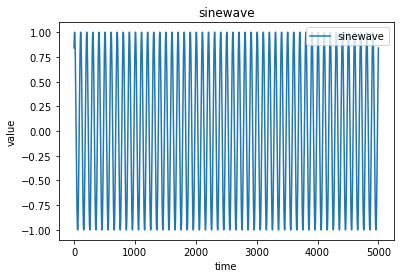

<Figure size 7200x720 with 0 Axes>

In [10]:
                """Data loading"""
df = pd.read_csv('https://raw.githubusercontent.com/swlee23/Deep-Learning-Time-Series-Anomaly-Detection/master/data/sinewave.csv')
plt.plot(df['sinewave'])
plt.title('sinewave')
plt.ylabel('value')
plt.xlabel('time')
plt.legend(['sinewave'], loc='upper right')
plt.figure(figsize=(100,10))
plt.show()

In [0]:
              """Data preprocessing"""
# split a univariate sequence into samples
def split_sequence(sequence):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + w
		out_end_ix = end_ix + p_w
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
raw_seq = list(df['sinewave'])

# split into samples
batch_sample, batch_label = split_sequence(raw_seq)

# summarize the data
# for i in range(5):
# 	print(X[i], Y[i])
  
# 2. reshape from [samples, timesteps] into [samples, timesteps, features]

# need to convert batch into 3D tensor of the form [batch_size, input_seq_len, n_features]
batch_sample = batch_sample.reshape((batch_sample.shape[0], batch_sample.shape[1], n_features))

In [12]:
              """Generate model for predictor"""
model = Sequential()

# Convolutional Layer #1
# Computes 32 features using a 1D filter(kernel) of with w with ReLU activation. 
# Padding is added to preserve width.
# Input Tensor Shape: [batch_size, w, 1] / batch_size = len(batch_sample)
# Output Tensor Shape: [batch_size, w, num_filt_1] (num_filt_1 = 32 feature vectors)
model.add(Conv1D(filters=num_filt_1,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu',
                 input_shape=(w, n_features)))

# Pooling Layer #1
# First max pooling layer with a filter of length 2 and stride of 2
# Input Tensor Shape: [batch_size, w, num_filt_1]
# Output Tensor Shape: [batch_size, 0.5 * w, num_filt_1]

model.add(MaxPooling1D(pool_size=pool_size_1)) 
                    #  strides=pool_strides_1, 
                    #  padding='valid'))

# Convolutional Layer #2
# Computes 64 features using a 5x5 filter.
# Padding is added to preserve width and height.
# Input Tensor Shape: [batch_size, 0.5 * w, 32]
# Output Tensor Shape: [batch_size, 0.5 * w, num_filt_1 * num_filt_2]
model.add(Conv1D(filters=num_filt_2,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu'))

# Max Pooling Layer #2
# Second max pooling layer with a 2x2 filter and stride of 2
# Input Tensor Shape: [batch_size, 0.5 * w, num_filt_1 * num_filt_2]
# Output Tensor Shape: [batch_size, 0.25 * w, num_filt_1 * num_filt_2]
model.add(MaxPooling1D(pool_size=pool_size_2))
                    #  strides=pool_strides_2, 
                    #  padding='valid'
          
# Flatten tensor into a batch of vectors
# Input Tensor Shape: [batch_size, 0.25 * w, num_filt_1 * num_filt_2]
# Output Tensor Shape: [batch_size, 0.25 * w * num_filt_1 * num_filt_2]
model.add(Flatten())

# Dense Layer (Output layer)
# Densely connected layer with 1024 neurons
# Input Tensor Shape: [batch_size, 0.25 * w * num_filt_1 * num_filt_2]
# Output Tensor Shape: [batch_size, 1024]
model.add(Dense(units=num_nrn_dl, activation='relu'))  

# Dropout
# Prevents overfitting in deep neural networks
model.add(Dropout(dropout_rate))

# Output layer
# Input Tensor Shape: [batch_size, 1024]
# Output Tensor Shape: [batch_size, p_w]
model.add(Dense(units=num_nrn_ol))

# Summarize model structure
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 99, 32)            96        
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 49, 32)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 48, 32)            2080      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 24, 32)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 768)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 40)                30760     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
__________

In [13]:
               '''configure model'''
model.compile(optimizer='adam', 
              loss='mean_absolute_error')

# sgd = keras.optimizers.SGD(lr=learning_rate, 
#                          decay=1e-6, 
#                          momentum=0.9, 
#                          nesterov=True)
# model.compile(optimizer='sgd', 
#               loss='mean_absolute_error', 
#               metrics=['accuracy'])

W0703 08:40:13.792390 140679940499328 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [14]:
                    '''Training'''
model_fit = model.fit(batch_sample,
                      batch_label,
                      epochs=epochs,
                      verbose=1)

W0703 08:40:17.620489 140679940499328 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/30
4897/4897 [==============================] - 1s 276us/step - loss: 0.2515
Epoch 2/30
4897/4897 [==============================] - 1s 200us/step - loss: 0.1804
Epoch 3/30
4897/4897 [==============================] - 1s 201us/step - loss: 0.1668
Epoch 4/30
4897/4897 [==============================] - 1s 199us/step - loss: 0.1577
Epoch 5/30
4897/4897 [==============================] - 1s 194us/step - loss: 0.1518
Epoch 6/30
4897/4897 [==============================] - 1s 189us/step - loss: 0.1511
Epoch 7/30
4897/4897 [==============================] - 1s 192us/step - loss: 0.1463
Epoch 8/30
4897/4897 [==============================] - 1s 195us/step - loss: 0.1536
Epoch 9/30
4897/4897 [==============================] - 1s 194us/step - loss: 0.1481
Epoch 10/30
4897/4897 [==============================] - 1s 199us/step - loss: 0.1480
Epoch 11/30
4897/4897 [==============================] - 1s 195us/step - loss: 0.1472
Epoch 12/30
4897/4897 [==============================] - 1s 207

In [15]:
        '''Visualization of training/test accuracy'''
print(model_fit.history.keys())
# summarize history for accuracy
plt.plot(model_fit.history['accuracy'])
plt.plot(model_fit.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

dict_keys(['loss'])


KeyError: ignored

In [20]:
                      """Testing"""
# Set number of test sequences 
n_test_seq = 3

# Split a univariate sequence into samples
def generate_test_batch(raw_seq, n_test_seq):
  # Sample a portion of the raw_seq randomly
    ran_ix = random.randint(0,len(raw_seq) - n_test_seq * w - n_test_seq * p_w)
    raw_test_seq = array(raw_seq[ran_ix:ran_ix + n_test_seq * w +  n_test_seq * p_w])
    batch_test_seq, batch_test_label = list(), list()
    ix = ran_ix
    for i in range(n_test_seq):
        # gather input and output parts of the pattern
        seq_x = raw_seq[ix : ix+w],
        seq_y = raw_seq[ix+w : ix+w+p_w]
        ix = ix+w+p_w
        batch_test_seq.append(seq_x)
        batch_test_label.append(seq_y)
    return array(batch_test_seq), array(batch_test_label)

batch_test_seq, batch_test_label = generate_test_batch(list(df['sinewave']), n_test_seq)
batch_test_seq = batch_test_seq.reshape((batch_test_seq.shape[0], w, n_features))
batch_test_label = batch_test_label.reshape((batch_test_label.shape[0], p_w))

# Returns the loss value & metrics values for the model in test mode
model.evaluate(x=batch_test_seq,
               y=batch_test_label,
               verbose=1) 

3/3 [==============================] - 0s 15ms/step


0.07324299961328506

In [0]:
                  """Save Weights"""
# save it to disk so we can load it back up anytime
model.save_weights('sinwave_model_1.h5')  

In [31]:
                   """Predicting"""
# Build model 
model = Sequential()
model.add(Conv1D(filters=num_filt_1,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu',
                 input_shape=(w, n_features)))
model.add(MaxPooling1D(pool_size=pool_size_1)) 
model.add(Conv1D(filters=num_filt_2,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu'))
model.add(MaxPooling1D(pool_size=pool_size_2))
model.add(Flatten())
model.add(Dense(units=num_nrn_dl, activation='relu')) 
model.add(Dropout(dropout_rate))
model.add(Dense(units=num_nrn_ol))

# Load the model's saved weights.
model.load_weights('sinwave_model_1.h5')
          
# Sample a portion of the raw_seq randomly
# 1. Choose 
ran_ix = random.randint(1,len(raw_seq) - w - p_w)
test_seq = array(raw_seq[ran_ix : ran_ix + w])
target_label = array(raw_seq[ran_ix + w : ran_ix + w + p_w])
x_input = array(test_seq)
x_input = x_input.reshape((1, w, n_features))

# Predict the next time stampes of the sampled sequence
yhat = model.predict(x_input, verbose=1)

# Print our model's predictions.
print(yhat)

# Check our predictions against the ground truths.
print(target_label) # [7, 2, 1, 0, 4]

ValueError: ignored

In [0]:
                """Anomaly detector"""
def anomaly_detector(prediction_seq, ground_truth_seq):
    # calculate Euclidean between actual seq and predicted seq
    dist = np.linalg.norm(ground_truth_seq - prediction_seq)  
    if (dist > anm_det_thr):
        return true  # anomaly
    else:
        return false # normal 

In [0]:
           '''Visualization of predicted time series'''


In [28]:
# Shallow CNN version  
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=1000, verbose=1)
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=1)
print(yhat)

Epoch 1/1000
5/5 [==============================] - 0s 71ms/step - loss: 3884.4077
Epoch 2/1000
5/5 [==============================] - 0s 703us/step - loss: 3786.6868
Epoch 3/1000
5/5 [==============================] - 0s 393us/step - loss: 3676.9297
Epoch 4/1000
5/5 [==============================] - 0s 360us/step - loss: 3565.9961
Epoch 5/1000
5/5 [==============================] - 0s 485us/step - loss: 3454.5906
Epoch 6/1000
5/5 [==============================] - 0s 413us/step - loss: 3342.7297
Epoch 7/1000
5/5 [==============================] - 0s 442us/step - loss: 3230.0688
Epoch 8/1000
5/5 [==============================] - 0s 460us/step - loss: 3117.0239
Epoch 9/1000
5/5 [==============================] - 0s 479us/step - loss: 3004.1084
Epoch 10/1000
5/5 [==============================] - 0s 494us/step - loss: 2891.7153
Epoch 11/1000
5/5 [==============================] - 0s 401us/step - loss: 2780.0889
Epoch 12/1000
5/5 [==============================] - 0s 377us/step - loss: 